## Music Synthesis

### 1. Additive Synthesis:
This method synthesizes sounds by constructing a complex tone made of a fundamental and several harmonics. The tone is obtained by adding together all these components.

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import freqz, sosfreqz

**define function to generate complex tone using additive synthesis**

In [4]:
def generate_complex_tone(f0,fs,amplitudes,phases,duration,n_comp):
    """
    Arguments:
    f0 = fundamental frequency
    fs = sampling frequency
    amplitudes,phases = absolute amplitude and phase value for f0 and
    the harmonics
    
    Returns the complex tone signal
    """
    assert len(amplitudes) == n_comp,"Incorrect no. of amplitudes given"
    assert len(phases) == n_comp, "Incorrect no. of phases are given"
    
    n = np.arange(0,duration*fs)
    x = np.zeros(len(n))
    
    for i in range(len(amplitudes)):
        x = x + amplitudes[i]*np.sin(2*np.pi*(i+1)*(f0/fs)*n + phases[i])
    return x

**set the parameters for synthesis**

In [5]:
pi = np.pi
f0 = 500  # in Hz
fs = 16000    # in samples per second
n_comp = 10
amplitudes = [2,1.6,1.8,1.5,1.2,1,0.8,0.6,0.4,0.1] # list with n_comp different amplitudes for different harmonics
# phases = [pi/2,pi/2,pi/2,pi/2,pi/2,pi/2,pi/2,pi/2,pi/2,pi/2]
phases = np.zeros(10)
duration = 3 # in seconds

**call the function to generate the tone and plot it's waveform and magnitude specturm**

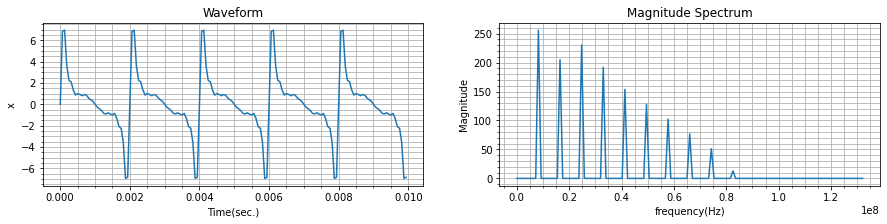

In [6]:
%matplotlib inline

# Generate a tone based on the above specifications
x = generate_complex_tone(f0,fs,amplitudes,phases,duration,n_comp)

# calculate the DFT of x
n_fft = 256
x_spec = np.fft.rfft(x,n_fft)

t = np.arange(len(x))/fs
f = np.arange(len(x_spec))*fs/2*len(x_spec)

# plot the waveform
fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(t[:5*fs//f0], x[:5*fs//f0])
ax[0].set(title = 'Waveform',
         xlabel = 'Time(sec.)',
         ylabel = 'x')
ax[0].minorticks_on()
ax[0].grid(which='both');

#plot the magnitude spectrum
ax[1].plot(f,np.abs(x_spec))
ax[1].set(title = 'Magnitude Spectrum',
         xlabel = 'frequency(Hz)',
         ylabel = 'Magnitude')
ax[1].minorticks_on()
ax[1].grid(which='both');

plt.show()
ipd.display(ipd.Audio(data=x, rate=fs))


### 2. Subtractive synthesis:
* makes use of source-filter model for sound synthesis
* source excitation like impulse train is filtered by an LTI system such as an all pole resonator<br>
**steps**
* Generate the source excitation
* Design the filter
* Filter the source signal using designed filter

**Function to generate the source excitation**

In [7]:
def generate_source(f0,fs,duration,plot=True):
    """
    Arguments:
    f0 : fundamental frequency
    fs : sampling frequency
    Returns a source (triangular) impulse train 
    and plots thewaveform
    """
    
    Ts = 1.0/fs
    source = np.zeros(int(duration/Ts))#initialize source signal array
    interval = int((1/f0)/Ts)# spacing betn two consecutive impulses
    locs = np.arange(0, len(source),interval) #locations of impulses
    source[locs-1] = 0.5
    source[locs] = 1
    source[locs+1] = 0.5
    
    if plot == True:
        fig1 = plt.figure()
        t = np.arange(0,10.0/f0,Ts)
        plt.plot(t,source[:len(t)])
        plt.ylabel('Amplitude')
        plt.xlabel('Time(sec.)')
        plt.title('source excitation')
        plt.minorticks_on()
        plt.grid(which='both')
        plt.show()
    return source
        

**designing a one-pole(single-formant) IIR filter and generating the denominator coefficients**

In [8]:
def generate_filter_single(f1,b1,fs,plot=True):
    """
    Arguments:
    f1: resonating frequency
    b1: resonating frequency bandwidth
    Returns the denominator coeff. of a single formant resonator
    filter and plots the frequency response and impulse response
    for the filter
    """
    Ts = 1.0/fs #sampling period
    r1 = np.exp(-1*np.pi*b1*Ts) # pole radius
    theta1 = 2*np.pi*f1*Ts
    denom = [1, -2*r1*np.cos(theta1), np.square(r1)]# denom. coeff. of filter TF 
    w,h = freqz([1], denom, whole=False) #filter TF
    
    if plot == True:
        print('\nFilter response\n')
        fig, ax = plt.subplots(1,2,figsize=(10,3))
        f = w*(fs/(2*math.pi))
        h = 20*np.log10(np.abs(h))
        ax[0].plot(f,h)
        ax[0].set(title = 'Magnitude response',
                 xlabel = 'frequency(Hz)',
                 ylabel = 'Magnitude(dB)')
        ax[0].minorticks_on()
        ax[0].grid(which='both')
        
        t = np.arange(0,0.01,Ts)
        h = np.exp(-1*np.pi*b1*t)*np.sin(2*np.pi*f1*t)
        ax[1].plot(t,h) # filter impulse response
        ax[1].set(title='Filter impulse response',
                 xlabel='time',
                 ylabel='magnitude')
        ax[1].minorticks_on()
        ax[1].grid(which='both')
        plt.show()
        
    return denom
                

**filtering the source signal using the above filter using a difference equation** 

In [9]:
def filter_lti(source, denom, f0, fs, plot=True):
    """
    Arguments:
    source :source(impulse train) signal
    denom : denominator coeff. of the signal
    f0 : fundamental freq. of signal
    fs : sampling rate
    
    Returns the output of passing a source excitation signal 
    through a filter using difference equation method to apply
    the LTI filter.
    """
    Ts = 1.0/fs
    interval = int((1.0/f0)/Ts)
    y = np.zeros(len(source))
    y[0] = source[0]
    y[1] = source[1] - denom[1]*y[0]
    for i in range(2, len(y)):
        y[i] = source[i] - denom[1]*y[i-1] - denom[2]*y[i-2]
        
    
    if plot == True:
        noCycles = 5
        fig2 = plt.figure()
        plt.plot(t[0:noCycles*interval],y[0:noCycles*interval])
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('Waveform of the filtered signal.')
        plt.minorticks_on()
        plt.grid(which = 'both');
        plt.show()
        
    return y
    

**set the parameters for the synthesis**

In [10]:
f0 = 140
fs = 16000
duration = 1
f1 = 500   # formant frequency
b1 = 100    # bandwidth of the formant

**Generate the source signal, obtain the filter then apply it to source signal**

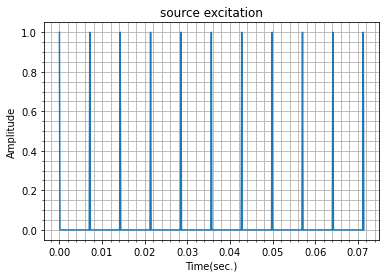


Filter response



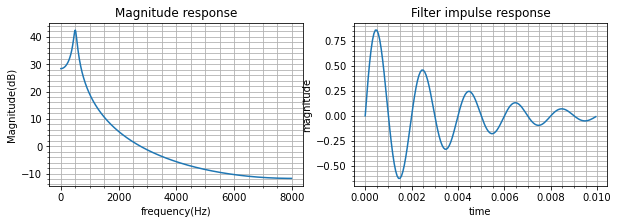

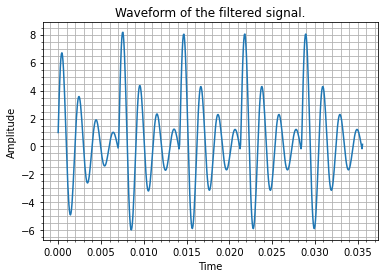

In [11]:
%matplotlib inline
# generate the source signal
x = generate_source(f0,fs,duration)
ipd.display(ipd.Audio(data=x, rate=fs))

# obtain the filter coeff.
denom = generate_filter_single(f1,b1,fs)

# filter the source
y = filter_lti(x,denom,f0,fs)
ipd.display(ipd.Audio(data=y, rate=fs))


**Same synthesis as above but by using three-formant filter which is cascade of three second-order sections**

**function for 3-formant filter**

In [12]:
def generate_filter_3form(f0,f1,f2,f3,b1,fs):
    """
    Arguments:
    f0: source excitation frequency
    f1, f2, f3: resonating frequencies
    b1: resonating frequency bandwidth
    fs: sampling rate
    
    Returns: denoms-tuple of three sets of denom coeff.
    """
    Ts = 1.0/fs
    r1 = np.exp(-1*np.pi*b1*Ts)
    theta1 = 2*np.pi*f1*Ts
    theta2 = 2*np.pi*f2*Ts
    theta3 = 2*np.pi*f3*Ts
    denom1 = [1, -2*r1*np.cos(theta1),np.square(r1)]
    denom2 = [1, -2*r1*np.cos(theta2),np.square(r1)]
    denom3 = [1, -2*r1*np.cos(theta3),np.square(r1)]
    
    return (denom1,denom2,denom3)
    

**Let's set the above f1,f2,f3 to those of some vowels in the english**

In [13]:
f0 = 120
formant_freqs = {'a':[730,1090,2440],
                'i':[270, 2290, 3010],
                'u':[300,870,2240]}
b1 = 100
vowel = 'u'  # 'a' or 'i' or 'u'
f1,f2,f3 = formant_freqs[vowel]

**let's synthesize vowel like sound by using filter method**

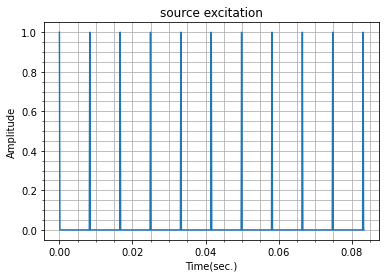

output of section:1


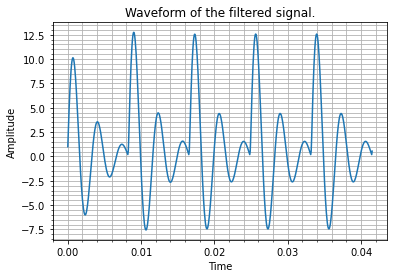

output of section:2


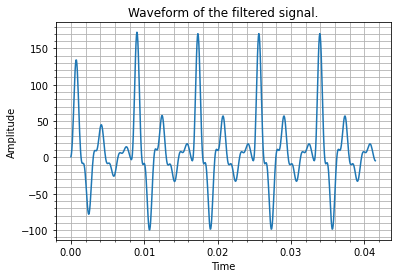

output of section:3


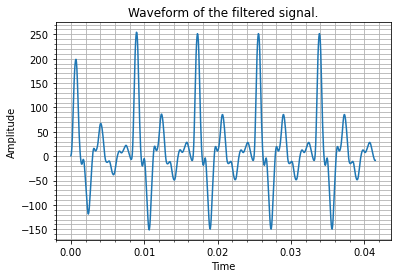

In [14]:
# Generate the excitation signal
x = generate_source(f0,fs,duration)
ipd.display(ipd.Audio(data=x,rate=fs))

# obtain the denominator coeff of filter
denoms = generate_filter_3form(f0,f1,f2,f3,b1,fs)

# apply this filters iteratively and plot the output of each second-order
# filter
y = x
i = 1
for denom in denoms:
    print(f'output of section:{i}')
    i = i+1
    y = filter_lti(y, denom,f0,fs)
    ipd.display(ipd.Audio(data=y,rate=fs))
    

### Generating a simple melody from the function blocks defined above

<br><br>
## 3. A simple example of generating a melody using the synthesis blocks from above

In this task, we will generate a melody by synthesizing the corresponding the notes and setting the durations of each note appropriately. You can use the chart below as a reference for the absolute F0 values of musical notes.

| Note | Freq (Hz)   | Note | Freq (Hz)   | Note | Freq (Hz)   |
|------|-------------|------|-------------|------|-------------|
|   C1 |     131     |   F  |     175     |   A# |     233     |
|   C# |     139     |   F# |     185     |   B  |     247     |
|   D  |     147     |   G  |     196     |   C2 |     262     |
|   D# |     156     |   G# |     208     |
|   E  |     165     |   A  |     220     |

Following is the note sequence(score) for a popular melody. Each tuple specifies (Note, #beats). Take 1 beat = 400 ms.  

(C,1) (C, 1) (D,2) (C,2) (F,2) (E,4);

(C,1) (C,1) (D,2) (C,2) (G,2) (F,4);

(C,1) (C,1) (C2,2) (A,2) (F,2) (E,2) (D,2);

(A#,1) (A#,1) (A,2) (F,2) (G,2) (F,4);

**convert the above note-freq chart and score to python dict and list resp.**

In [15]:
note_freq = {'C':131, 'C#':139, 'D':147, 'D#':156,
            'E':165, 'F':175, 'F#':185, 'G':196,
            'G#':208, 'A':220, 'A#':233, 'B':247, 'C2':262}
melody = [('C',1),('C',1),('D',2),('C',2),('F',2),('E',4),
         ('C',1), ('C',1), ('D',2), ('C',2), ('G',2), ('F',4), 
          ('C',1), ('C',1), ('C2',2), ('A',2), ('F',2), ('E',2), ('D',2),
          ('A#',1), ('A#',1), ('A',2), ('F',2), ('G',2), ('F',4)]


**Synthesize the above melody using any of the above 3 methods**

**1. A complex tone method**

In [16]:
fs = 16000
beat_duration = 400e-3  # sec

synth_song = np.array([])
for note in melody:
    f0 = note_freq[note[0]]
    duration = note[1]*beat_duration
    
    # to synthesize note using a complex tone method:
    x = generate_complex_tone(f0,fs,[1,1,1,1,1],[0,0,0,0,0],duration,5)
    
    # append to synth_array:
    synth_song = np.append(synth_song, x)
    
ipd.display(ipd.Audio(data=synth_song,rate=fs))

    


**2. Using one-formant resonator**

In [17]:
fs = 16000
beat_duration = 400e-3  # sec

synth_song = np.array([])
for note in melody:
    f0 = note_freq[note[0]]
    duration = note[1]*beat_duration
    
    # to synthesize note using a single formant resonator
    x = generate_source(f0,fs,duration,plot=False)
    denom = generate_filter_single(500,100,fs,plot=False)
    x = filter_lti(x,denom,f0,fs,plot=False)
    
    # append to synth_array:
    synth_song = np.append(synth_song, x)
    
ipd.display(ipd.Audio(data=synth_song,rate=fs))
    

**3. Using three-formant resonator**

In [18]:
fs = 16000
beat_duration = 400e-3  # sec

synth_song = np.array([])
for note in melody:
    f0 = note_freq[note[0]]
    duration = note[1]*beat_duration
    
    # using 3-formant resonator:
    x = generate_source(f0,fs,duration,plot=False)
    vowel='a'
    f1,f2,f3 = formant_freqs[vowel]
    denoms = generate_filter_3form(f0,f1,f2,f3,b1,fs)
    for denom in denoms:
        x = filter_lti(x,denom,f0,fs,plot=False)
        
    #append to synth_song array:
    synth_song = np.append(synth_song,x)
ipd.display(ipd.Audio(data=synth_song,rate=fs))


**Let's define function to generate different melodies using three-formant resonator**

In [19]:
def synthesizer(fs,beat_duration,melody,note_freq):
    synth_song = np.array([])
    for note in melody:
        f0 = note_freq[note[0]]
        duration = note[1]*beat_duration

        # using 3-formant resonator:
        x = generate_source(f0,fs,duration,plot=False)
        vowel='a'
        f1,f2,f3 = formant_freqs[vowel]
        denoms = generate_filter_3form(f0,f1,f2,f3,b1,fs)
        for denom in denoms:
            x = filter_lti(x,denom,f0,fs,plot=False)

        #append to synth_song array:
        synth_song = np.append(synth_song,x)
    return synth_song
        

In [20]:
fs = 16000
beat_duration = 400e-3  # sec
note_freq = {'C':131, 'C#':139, 'D':147, 'D#':156,
            'E':165, 'F':175, 'F#':185, 'G':196,
            'G#':208, 'A':220, 'A#':233, 'B':247, 'C2':262}
melody = [('C',1),('C',1),('D',2),('C',2),('F',2),('E',4),
         ('C',1), ('C',1), ('D',2), ('C',2), ('G',2), ('F',4), 
          ('C',1), ('C',1), ('C2',2), ('A',2), ('F',2), ('E',2), ('D',2),
          ('A#',1), ('A#',1), ('A',2), ('F',2), ('G',2), ('F',4)]

synth_song = synthesizer(fs,beat_duration,melody,note_freq)
ipd.display(ipd.Audio(data=synth_song,rate=fs))

**Let's try another melody**

**Melody: SA-RE-GA-MA-PA-DHA-NI-SAN---SAN-NI-DHA-PA-MA-GA-RE-SA**

<img src = 'Sargam.jpg'/>

In [21]:
note_freq2 = {'C4':261, 'D4':294,'E4':330, 'F4':349,'G4':392, 
             'A4':440, 'B4':494, 'C5':515}

melody2 = [('C4',2),('D4',2),('E4',2),('F4',2),('G4',2),('A4',2),
           ('B4',2), ('C5',2),('C5',2),('B4',2),('A4',2),('G4',2),
           ('F4',2),('E4',2),('D4',2),('C4',2)]

fs = 16000
beat_duration = 400e-3
synth_song2 = synthesizer(fs,beat_duration,melody2,note_freq2)
ipd.display(ipd.Audio(data=synth_song2,rate=fs))

### 2. Twinkle-Twinkle-Little-Star
**Melody3:**<br>
Twinkle, twinkle, little star<br>
How I wonder what you are<br>
Up above the world so high<br>
Like a diamond in the sky<br>
Twinkle, twinkle little star<br>
How I wonder what you are<br>

In [22]:

note_freq3 = {'C4':261, 'D4':294,'E4':330, 'F4':349,'G4':392, 
             'A4':440, 'B4':494, 'C5':515}

melody3 = [('C4',2),('C4',2),('G4',2),('G4',2),('A4',2),('A4',2),('G4',2),
           ('F4',2),('F4',2),('E4',2),('E4',2),('D4',2),('D4',2),('C4',2),
           ('G4',2),('G4',2),('F4',2),('F4',2),('E4',2),('E4',2),('D4',2),
           ('G4',2),('G4',2),('F4',2),('F4',2),('E4',2),('E4',2),('D4',2),
           ('C4',2),('C4',2),('G4',2),('G4',2),('A4',2),('A4',2),('G4',2),
           ('F4',2),('F4',2),('E4',2),('E4',2),('D4',2),('D4',2),('C4',2)
          ]
fs = 16000
beat_duration = 300e-3
synth_song3 = synthesizer(fs,beat_duration,melody3,note_freq3)
ipd.display(ipd.Audio(data=synth_song3,rate=fs))